In [1]:
from datasets import load_dataset, Dataset
import sys, os, json
sys.path.append(os.path.join(os.getcwd(), '../..'))
from OPRO import OPRO
import pandas as pd
from tqdm.auto import tqdm, trange

opro = OPRO(["gemini", "gemma", "anthropic"])
dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
CHOSEN_PROMPT = dataset["prompts"][404][0].replace("PLACEHOLDER", "{LANGUAGE}", 1).replace("PLACEHOLDER", "{TEXT}", 1)
CHOSEN_PROMPT

'Please help me to translate the following text to {LANGUAGE}. Please return only translated content not include the origin text. Here is the text: \n\n{TEXT}'

### Original Dataset

In [2]:
import pandas as pd
df = pd.read_csv("en-sp.csv")
df = df.sample(250, random_state=42)
df["english"] = df["english"].apply(lambda x: CHOSEN_PROMPT.format(LANGUAGE="Spanish", TEXT=x))
# df to dict without indices
df_dict = df.to_dict(orient='records')
# dict with two keys: english and spanish
original_data = {"question": [], "answer": []}
for row in df_dict:
    original_data["question"].append(row["english"])
    original_data["answer"].append(row["spanish"])
original_data = Dataset.from_dict(original_data)
original_data["question"][:5], original_data["answer"][:5]

(['Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nHow boring!',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nI love sports.',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nWould you like to swap jobs?',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nMy mother did nothing but weep.',
  'Please help me to translate the following text to Spanish. Please return only translated content not include the origin text. Here is the text: \n\nCroatia is in the southeastern part of Europe.'],
 ['¡Qué aburrimiento!',
  'Adoro el deporte.',
  '¿Te gustaría que intercambiemos los trabajos?',
 

### Generate Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers for the prompt: {CHOSEN_PROMPT}.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "question": \"\"\"{question}\"\"\",
    "answer": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step.
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            question=original_data["question"][0],
            answer=original_data["answer"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )
    return eval(response)

SYNTHETIC_DATA_FILEPATH = "synthetic_translations_dataset.json"
if not os.path.exists(SYNTHETIC_DATA_FILEPATH):
    qa_pairs = []
    SAMPLE_SIZE = 40

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open(SYNTHETIC_DATA_FILEPATH, "w") as f:
        f.write(str(qa_pairs))

# Reading saved data
with open(SYNTHETIC_DATA_FILEPATH, "r") as f:
    qa_pairs = eval(f.read())

qa_pairs

[{'question': 'Please help me to translate the following text to Portuguese. Please return only translated content not include the origin text. Here is the text: \n\nI want to buy an orange.',
  'answer': 'Quero comprar uma laranja.'},
 {'question': 'Please help me to translate the following text to German. Please return only translated content not include the origin text. Here is the text:\n\ntake a deep breath',
  'answer': 'tief durchatmen'},
 {'question': 'Please help me to translate the following text to Japanese. Please return only translated content not include the origin text. Here is the text: \n\nWhat is the meaning of life?',
  'answer': '人生の意味とは何か?'},
 {'question': "Please help me to translate the following text to Dutch. Please return only translated content not include the origin text. Here is the text: \n\nDon't touch my stuff.",
  'answer': 'Blijf van mijn spullen af.'},
 {'question': 'Kindly help me translate the following text to Portuguese. But make sure to give only

In [4]:
TRAINING_SAMPLE_SIZE = 10
TESTING_SAMPLE_SIZE = 25

training_sample = Dataset.from_dict(
    {
        "question": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "answer": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "question": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "answer": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["question"]), len(training_sample["answer"]), len(testing_sample["question"]), len(testing_sample["answer"])

(10, 10, 25, 25)

### Optimize Prompt on Synthetic Data

In [5]:
def opt_llm(instruction_score_pairs, training_sample):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    q1, q2, q3 = (
        training_sample["question"][0],
        training_sample["question"][1],
        training_sample["question"][2],
    )
    a1, a2, a3 = (
        training_sample["answer"][0],
        training_sample["answer"][1],
        training_sample["answer"][2],
    )
    response = opro.generate(
        prompt.format(pairs_str=pairs_str, q1=q1, a1=a1, q2=q2, a2=a2, q3=q3, a3=a3),
        model="gemini",  # gemini
        is_indeterministic=True
    )
    return response


def score(instruction, sample):
    """
    Score the instruction using the sample. 
    
    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    prompt = """{question}\n{instruction}"""
    with tqdm(sample, desc=instruction, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(question=sample_qa["question"], instruction=instruction),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += opro.similarity(sample_qa["answer"], res)
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [13]:
INS_PER_STEP = 8
EXEMPLARS_PER_STEP = 3
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_translations_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        "Think step by step.",
        "Take a deep breath and think step-by-step.",
        "Be concise and clear.",
        "You are the creator of an atlas.",
        "Explain your answer in simple terms.",
        
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            exemplars = training_sample.shuffle()[:EXEMPLARS_PER_STEP]
            instructions = [
                opt_llm(ins_score_pairs, exemplars)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Step 11


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

list index out of range


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Believe in your own potential.:   0%|          | 0/10 [00:00<?, ?it/s]

Focus on the main idea.:   0%|          | 0/10 [00:00<?, ?it/s]

Strive for continual improvement.:   0%|          | 0/10 [00:00<?, ?it/s]

The best way to learn is by making mistakes.:   0%|          | 0/10 [00:00<?, ?it/s]

Put all your effort into the task.:   0%|          | 0/10 [00:00<?, ?it/s]

You can always consult a guru for enlightenment.:   0%|          | 0/10 [00:00<?, ?it/s]

Keep learning and growing.:   0%|          | 0/10 [00:00<?, ?it/s]

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new …

Step 12


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Tailor the answer based on specific situations.:   0%|          | 0/10 [00:00<?, ?it/s]

A key to success is focusing on the task.:   0%|          | 0/10 [00:00<?, ?it/s]

Share and care:   0%|          | 0/10 [00:00<?, ?it/s]

Look at patterns and learn from them.:   0%|          | 0/10 [00:00<?, ?it/s]

Success breeds success.:   0%|          | 0/10 [00:00<?, ?it/s]

The best way to attain success is through hard work.:   0%|          | 0/10 [00:00<?, ?it/s]

Set clear and concise goals.:   0%|          | 0/10 [00:00<?, ?it/s]

Prioritize essential action.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 13


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Keep changes to a minimum.:   0%|          | 0/10 [00:00<?, ?it/s]

Learn from the information around you.:   0%|          | 0/10 [00:00<?, ?it/s]

Determine your purpose clearly.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace your uniqueness.:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer is the key to your success.:   0%|          | 0/10 [00:00<?, ?it/s]

Think outside the box.:   0%|          | 0/10 [00:00<?, ?it/s]

Embrace the power of adaptability.:   0%|          | 0/10 [00:00<?, ?it/s]

Keep your focus on the big picture.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 14


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Success breeds happiness.:   0%|          | 0/10 [00:00<?, ?it/s]

Make the most of your opportunities.:   0%|          | 0/10 [00:00<?, ?it/s]

Preparation is the key to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Keep calm and believe in your heart.:   0%|          | 0/10 [00:00<?, ?it/s]

Answers make a path to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer, the key to your success.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success is your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Validate your response.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 15


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Answer is the gate to success.:   0%|          | 0/10 [00:00<?, ?it/s]

The key of your success lies in your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Remember, your answer is the key to your success.:   0%|          | 0/10 [00:00<?, ?it/s]

Answers are the key to your triumph.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to your success is within your reach.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success lies in taking the right actions.:   0%|          | 0/10 [00:00<?, ?it/s]

The answer is key to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Answers pave their way to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 16


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Generate a new unique text that is different from the old ones and has a score as high as possible.
Generate t…

Take things one step at a time.:   0%|          | 0/10 [00:00<?, ?it/s]

Separate your answer into two levels using two commas.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success is your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Clear your mind and stay focused:   0%|          | 0/10 [00:00<?, ?it/s]

Your success lies in your answers.:   0%|          | 0/10 [00:00<?, ?it/s]

Validate and improve your response.:   0%|          | 0/10 [00:00<?, ?it/s]

Mistakes prepare you to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 17


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Stay focused and keep going:   0%|          | 0/10 [00:00<?, ?it/s]

Seek out new opportunities.:   0%|          | 0/10 [00:00<?, ?it/s]

Success secrets are everywhere, take action.:   0%|          | 0/10 [00:00<?, ?it/s]

Analyze and grow from failures.:   0%|          | 0/10 [00:00<?, ?it/s]

Answers pave the way to achievement.:   0%|          | 0/10 [00:00<?, ?it/s]

Your key to enduring success is your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Take your time and do it well.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success lies within you.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 18


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

The answer is within your reach.:   0%|          | 0/10 [00:00<?, ?it/s]

Answer smart questions:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer provides the key to your success.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success is your answer and your dedication.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success is your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer, the surest way to win.:   0%|          | 0/10 [00:00<?, ?it/s]

Solutions to problems, keys to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Validate your answers regularly:   0%|          | 0/10 [00:00<?, ?it/s]

Step 19


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Your answer: the key unlocks success.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success is an answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Success is born from your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to unlocking potential is within your grasp.:   0%|          | 0/10 [00:00<?, ?it/s]

The answer provides the key to your success.:   0%|          | 0/10 [00:00<?, ?it/s]

Patience is the ultimate key to success.:   0%|          | 0/10 [00:00<?, ?it/s]

Answers power your way to achievement.:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer to success is the key.:   0%|          | 0/10 [00:00<?, ?it/s]

Step 20


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Discover the key to unlocking your potential.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success is your response.:   0%|          | 0/10 [00:00<?, ?it/s]

Success is forged from the answers you provide.:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer will unlock the full potential within you.:   0%|          | 0/10 [00:00<?, ?it/s]

The key to success lies within your answer.:   0%|          | 0/10 [00:00<?, ?it/s]

Your answer lies within the grasp of your understanding.:   0%|          | 0/10 [00:00<?, ?it/s]

Answer the key to success is your:   0%|          | 0/10 [00:00<?, ?it/s]

The key to your success is the answer.:   0%|          | 0/10 [00:00<?, ?it/s]

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

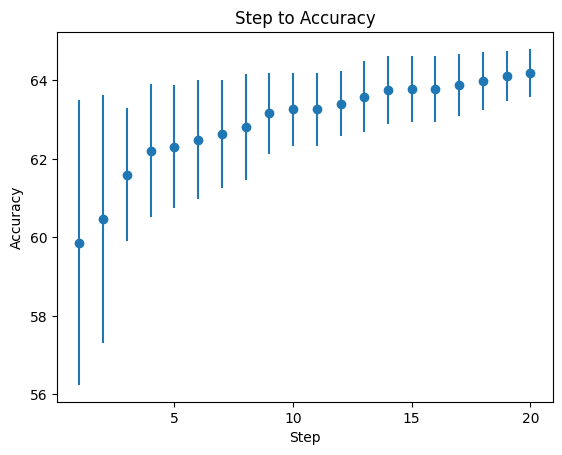

In [14]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [15]:
opro_results[str(len(opro_results))]

{'Your answer is the key to your success.': 65.66223174333572,
 'Validate your answer': 65.02991706132889,
 'Your answer, the key to your success.': 64.91064041852951,
 'Your answer is the key to success.': 64.84415411949158,
 'Mistakes may happen.': 64.7870683670044,
 'The key to success is your response.': 64.61671471595764,
 'Your answer to success is the key.': 64.53159302473068,
 'The key to success is your answer.': 64.33402746915817,
 'Your answer provides the key to your success.': 64.11198765039444,
 'Answers pave the way to achievement.': 64.10623699426651,
 'Success breeds success.': 63.83278429508209,
 'The key to your success is the answer.': 63.807052969932556,
 'Focus on smaller tasks.': 63.75780805945397,
 'Your key to enduring success is your answer.': 63.746732026338584,
 'Success is born from your answer.': 63.714466989040375,
 'Select ideas from two different sources.': 63.71038526296615,
 'The answer is within your reach.': 63.6588191986084,
 'Explain your answer i

In [16]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', testing_sample)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, testing_sample)}")

  0%|          | 0/25 [00:00<?, ?it/s]

No instruction: 62.44758391380309


Your answer is the key to your success.:   0%|          | 0/25 [00:00<?, ?it/s]

With best instruction (Your answer is the key to your success.): 63.10949492454528


In [17]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', original_data)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, original_data)}")

  0%|          | 0/250 [00:00<?, ?it/s]

No instruction: 69.03939652889967


Your answer is the key to your success.:   0%|          | 0/250 [00:00<?, ?it/s]

With best instruction (Your answer is the key to your success.): 63.88516544401646


In [18]:
prompt = """{question}\n{instruction}"""
res = opro.generate(
    prompt.format(question=original_data["question"][0], instruction=best_instruction),
    model="gemma",  # gemma
)
original_data["answer"][0], res, opro.similarity(original_data["answer"][0], res)

('¡Qué aburrimiento!',
 'Cómo aburrido!\nTu respuesta es el secreto para tu éxito.',
 0.6406172513961792)